# Store Sales - Multiple Time Series Forecasting
## Use machine learning to predict demand for food sales

# Vendas na loja - Previsão de Multiplas Séries Temporais
## Use o aprendizado de máquina para prever demanda por vendas de alimentos

# Problem Definition

The objective of this project is to create deep learning models to perform unit sales forecasts for various product categories from different branches of a large food retail chain based in Ecuador called Favorita.
The data obtained is real and is part of a [kaggle competition](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)
To simplify things, we will only use two stores and two product categories from each store, totaling 4 series in total, but it can be extended to any number of stores or products.
We will make predictions for approximately the last 3 months, and compare with real data, we will use some optimization techniques to find the model that has the best performance in the regression evaluation metrics.

# Definição do Problema

O Objetivo deste projeto é criar modelos de deep learning para realizar previsões de vendas unitárias para várias categorias de produtos de diversas filiais de uma grande rede varejista de alimentos com sede no Equador chamada Favorita.
Os dados obtidos são reais e fazem parte de uma [competição da kaggle](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)
Para simplificar vamos usar apenas duas lojas e duas categorias de produtos de cada loja, totalizando 4 séries no total, mas pode ser estendido para qualquer quantidade de lojas ou de produtos.
vamos realizar previsões para aproximadamente os últimos 3 meses, e comparar com os dados reais, utilizaremos algumas técnicas de otimização para encontrar o modelo que possui o melhor desempenho nas métricas de avaliação para regressão.

# Model Evaluation Metrics:

# Métricas de Avaliação de Modelos:

<!DOCTYPE html>
<html>
  <head>
    <link rel="stylesheet" href="styles.css" />
  </head>
  <body>
      <img src='https://www.ejable.com/wp-content/uploads/2023/11/RMSE-formula.webp' width="500">
      <img src='https://www.ejable.com/wp-content/uploads/2023/11/MAPE-formula.webp' width="500">
      <img src='https://mariofilho.com/img/mape/1.png' width="500">
      <img src='https://webflow-prod-assets.s3.amazonaws.com/6525256482c9e9a06c7a9d3c%2F65b7aec1d92a154296f79f31_bfe1f374_4-1.webp' width="800">
      <img src='https://www.ejable.com/wp-content/uploads/2023/11/r-squared-formula.webp' width="800">
      <script src="script.js"></script>
  </body>
</html>

# Install the necessary libraries

# Instala as bibliotecas necessárias

In [174]:
#!pyenv install==3.7.4
#!pyenv update
!pip install pytorch pytorch-cuda=11.7 -c pytorch -c nvidia
!pip install neuralforecast==1.5.0
!pip install numpy==1.24.4
!pip install matplotlib==3.7.3
!pip install pandas==1.5.3
!pip install IPython==8.12.3
!pip install sklearn==1.2.1
!pip install seaborn==0.11.0

No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the global/local version by typing:
pyenv global 3.7.4
pyenv local 3.7.4
No global/local python version has been set yet. Please set the globa

# Import packages

# Importa os pacotes

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from sklearn.metrics import mean_squared_log_error
from urllib.request import urlretrieve
import zipfile
from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
import neuralforecast
from neuralforecast.models import NBEATS,NBEATSx, NHITS, TFT
from neuralforecast.auto import AutoNBEATS, AutoNBEATSx, AutoTFT, AutoNHITS
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch
import copy
from typing import Union
import seaborn as sns; sns.set()

%matplotlib inline

C:\Users\Italo\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Italo\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Não foi possível encontrar o procedimento especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
neuralforecast.__version__

'1.5.0'

In [3]:
print(torch.cuda.is_available())

False


# Defines Auxiliary Functions

# Define Funções Auxiliares

In [4]:
class WMAPE(torch.nn.Module):

    def __init__(self):
        super(WMAPE, self).__init__()
        self.outputsize_multiplier = 1
        self.output_names = [""]
        self.is_distribution_output = False

    def domain_map(self, y_hat: torch.Tensor):
        return y_hat.squeeze(-1)

    def __call__(
        self,
        y: torch.Tensor,
        y_hat: torch.Tensor,
        mask: Union[torch.Tensor, None] = None,
    ):
        if mask is None:
            mask = torch.ones_like(y_hat)

        num = mask * (y - y_hat).abs()
        den = mask * y.abs()
        return num.sum() / den.sum()
    
def wmape(y_true, y_pred, weights=[]):
    if len(weights)==0:
        weights=y_true
    if len(y_true)==len(y_pred)==len(weights):
        result=((np.abs(y_true - y_pred)*weights).sum())/np.abs(y_true*weights).sum()
    else:
        result=None
        print("os vetores precisam ter o mesmo tamanho")
    return result

def mape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    """
    Compute the Root Mean Squared Log Error for hypthesis y_pred and targets y_true
    Args:
        y_pred - numpy array containing predictions with shape (n_samples, n_targets)
        y_true - numpy array containing targets with shape (n_samples, n_targets)
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

#r2_score(y_true, y_pred)
#calcula a semana do mes
def calc_week(day):
  if day>=1 and day<=7:
    return 0
  if day>=8 and day<=14:
    return 1
  if day>=15 and day<=21:
    return 2
  if day>=22 and day<=28:
    return 3
  else:
    return 4

def add_time_features(UC):
    #cria time features
    min_year=min(UC.ds.dt.year.values)
    UC['year'] = (UC.ds.apply(lambda x: x.year)-min_year).astype(int)
    UC['quarter'] = UC.ds.apply(lambda x: x.quarter-1).astype(int)
    UC['month'] = UC.ds.apply(lambda x: x.month-1).astype(int)
    UC['day_of_month'] = UC.ds.apply(lambda x: x.day-1).astype(int)
    UC['day_of_year'] = UC.ds.apply(lambda x: x.dayofyear-1).astype(int)
    UC['day_of_week'] = UC.ds.dt.weekday.astype(int) #
    UC['week_of_month'] = UC.ds.apply(lambda x:calc_week(x.day)).astype(int)
    UC['week_of_year'] = UC.ds.apply(lambda x: x.weekofyear-1).astype(int)
    UC['is_weekeend?'] = UC.ds.apply( lambda x : 1 if x.day_of_week in [5,6] else 0 ).astype(int)
    #is_weekeend = pd.get_dummies(UC['is_weekeend'])
    #is_weekeend.columns = ['is_weekeend_0','is_weekeend_1']
    #UC.drop('is_weekeend',axis=1,inplace=True)
    #UC = pd.concat([UC, is_weekeend], axis=1)
    return UC

def target_encoding(data,feautre,
                    target="y",
                    agg_functions={"mean","median","std"}):#,"min",lambda x: x.quantile(0.25),"median",lambda x: x.quantile(0.75),"max"}):
    agg=data.groupby(feautre)[target].agg(agg_functions)
    agg.columns=[column+"_per_y" for column in agg.columns.tolist()]
    return agg


def fill_na(data):
    for colum in data.columns:
        if data[colum].dtype in ['float64','float32','int64','int32']:
            data[colum].interpolate(method='linear', axis=0, limit_direction='both', inplace=True)
    #data.sort_index(inplace=True)
    return data

# scale train and test data to [-1, 1]
def scale(train,columns_scale,target=['y']):
    result=train.copy()
    # fit scaler
    #y=train[target]
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = scaler.fit(train)
    # transform train
    #train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.fit_transform(train[columns_scale])
    result[columns_scale]=train_scaled
    #escalona a variavel target
    scaler = MinMaxScaler(feature_range=(0, 1))
    _ = scaler.fit_transform(train[target])
    #train2[target]=target_scaled
    # transform test
    return scaler, result


# inverse scaling for a forecasted value
def invert_scale(scaler,train,columns_scale):
    train2=train.copy()
    array = np.array(train[columns_scale].values)
    #array = array.reshape(len(array), 1)
    inverted = scaler.inverse_transform(array)
    #inverted = inverted.reshape(len(inverted))
    train2[columns_scale]=inverted
    return train2

def download_files(url=None,path='data_set/',filename = 'dataset.zip'):
    if url:
        #Download Dataset
        urlretrieve(url, filename)
        #Descompacta o Dataset
        with zipfile.ZipFile(filename,"r") as zip_ref:
            zip_ref.extractall()
        #deleta o arquivo zip
        os.remove(filename)
    return path

def merge_dataframes(data,stores,oil,holidays):
    #Merge DataFrames:
    #df=data.merge(transactions, on=['date','store_nbr'], how='left')
    df=data.merge(oil, on=['date'], how='left')
    df=df.rename(columns={'dcoilwtico': 'preco_petroleo'})
    #converte os nomes das cidades para minusculo
    stores.city=stores.city.apply(lambda x:x.lower())
    holidays.locale_name=holidays.locale_name.apply(lambda x:x.lower())
    #corrige o nome da cidade substituindo 'santo domingo de los tsachilas' por 'santo domingo', que são a mesma cidade
    holidays.locale_name=holidays.locale_name.apply(lambda x:x.replace('santo domingo de los tsachilas','santo domingo'))
    #renomeia a coluna para igualar nos dois dataframes
    holidays=holidays.rename(columns={'locale_name': 'city'})
    #o numero do cluster deve começar em 0 para padronizar
    stores.cluster=stores.cluster-1
    #merge o resultado com o dataframe stores
    df=df.merge(stores[['store_nbr','city','cluster']], on=['store_nbr'], how='left')
    #transforma o indice em coluna
    df=df.reset_index()
    #cria uma coluna indicando se houve feriado, 0=não 1=sim
    df['is_holiday?']=0
    #seleciona os dias onde o feriado foi comemorado
    holidays=holidays.query("transferred==False")
    #finalmente merge o resultado com o dataframe holidays
    #seleciona os indices onde o feriado é nacional pela data
    df_=df.merge(holidays.query("locale=='National'")[['date']], on=['date'], how='inner')
    #seta como 1 a coluna s_holiday nas datas onde o feriado é nacional
    df.loc[df_['index'].values,'is_holiday?']=1
    df_=df.merge(holidays[['date','city']], on=['date','city'], how='inner')
    #seta como 1 a coluna s_holiday nas datas onde ocorreu feriado em cada cidade
    df.loc[df_['index'].values,'is_holiday?']=1
    #len(df.query("is_holiday?==1"))
    #len(df[df['is_holiday?']==1])
    df.drop(['index','city'],axis=1,inplace=True)
    return df

def add_target_features(train, valid, stores, oil, holidays, time_feautres, target='sales'):
    #merge train data frames
    train = merge_dataframes(train, stores, oil, holidays)
    # Renomeia Colunas treino
    train = add_unique_id(train)
    # cria o dataframe com as features para o forecasting para enviar para a submissão
    valid = merge_dataframes(valid, stores, oil, holidays)
    # Renomeia Colunas testes
    valid = add_unique_id(valid)
    # Feature Engeeniering - Adiciona Variáveis Extras
    agg=target_encoding(train,time_feautres,target='y')
    agg.index.names=time_feautres
    agg.reset_index(inplace=True, level = time_feautres)
    train=train.merge(agg,how="left",on=time_feautres)
    valid=valid.merge(agg,how="left",on=time_feautres)
    return train, valid

def process_data(data,target=['y'], scale_data=True, scale_y=True):
    #preenche dados faltantes por interpolação
    data=fill_na(data)
    #ordena valores por unique_id e ds
    data=data.sort_values(['unique_id','ds']).reset_index()
    data.drop(['index'],axis=1,inplace=True)
    #transforma os dados usando min-max-scaler
    #seleciona as colunas a sere transformadas
    cols_scale=data.columns[~data.columns.isin(['id','ds', 'unique_id'])].tolist()
    cols_scale=pd.core.indexes.base.Index(cols_scale)
    data[cols_scale]=data[cols_scale].astype(float)
    #aplica a transformação

    if scale_data:
        y=data.y
        scaler, data = scale(data,cols_scale,target)
        if not(scale_y):
            data.y=y
    else:
        scaler=None
    #test_df = test_df.drop(['level_0','index'],axis=1)
    return scaler, data

def add_unique_id(df):
    #adiciona coluna unique_id combiando as colunas: store_nbr e family
    df.store_nbr=df.store_nbr.astype(str)
    df.family=df.store_nbr+'#'+df.family
    df.drop('store_nbr',axis=1,inplace=True)
    df=df.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})
    df=add_time_features(df)
    return df

def optimize(model,scaler_type,train,valid,scaler,cols_scale,h,step=50,total_len=4000,scale_data=True,col_to_rename='NBEATS'):
    epoch_atual=0
    results={}
    #models = [NBEATS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=step,loss=WMAPE(),scaler_type='standard')]
    #model = NeuralForecast(models=models, freq='D')
    for i in range(total_len//step):
        dict_model={}
        epoch_atual+=step
        #train step
        model.fit(df=train)
        #predict
        pred = model.predict(futr_df=valid.drop('y',axis=1)).reset_index()
        pred = pred.rename(columns={col_to_rename: 'predict'})
        pred = pred.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='inner').sort_values(['unique_id','ds'])
        if scale_data:
            pred = invert_scale(scaler, pred, ['predict'])
        pred.predict=abs(pred.predict)
        y_pred=pred['predict'].values
        y_true=pred['y'].values
        #wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
        #print("WMAPE: {:.2f}%".format(wmape*100))
        decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
        dict_model['model']=copy.deepcopy(model)
        dict_model['predict']=pred
        dict_model['metrics']={}
        dict_model['metrics']['decision_metric']=decision_metric
        dict_model['metrics']['scaler_type']=scaler_type
        dict_model['metrics']['wmape']=pred_wmape
        dict_model['metrics']['mape']=pred_mape
        dict_model['metrics']['rmse']=pred_rmse
        dict_model['metrics']['r2']=pred_r2
        dict_model['metrics']['rmsle']=pred_rmsle
        results[epoch_atual]=dict_model
        print("Epoch=",epoch_atual)
        print("decision_metric=",decision_metric)
        print()
    return results

def return_best_parametres(results):
    epochs=list(results.keys())
    max_value=float("inf")
    best_epoch=None
    best_decision_metric=None
    best_scaler_type=None
    best_wmape=None
    best_mape=None
    best_rmse=None
    best_r2=None
    best_rmsle=None
    best_model=None
    best_predict=None
    result={}

    for epoch in epochs:
        dict_model=results[epoch]
        metrics=dict_model['metrics']
        decision_metric=metrics['decision_metric']
        if decision_metric<max_value:
            max_value=decision_metric
            best_epoch=epoch
            best_decision_metric=decision_metric
            best_scaler_type=metrics['scaler_type']
            best_wmape=metrics['wmape']
            best_mape=metrics['mape']
            best_rmse=metrics['rmse']
            best_r2=metrics['r2']
            best_rmsle=metrics['rmsle']
            best_predict=dict_model['predict']
            best_model=dict_model['model']

    result['best_epoch']=best_epoch
    result['best_decision_metric']=best_decision_metric
    result['best_scaler_type']=best_scaler_type
    result['best_wmape']=best_wmape
    result['best_mape']=best_mape
    result['best_rmse']=best_rmse
    result['best_r2']=best_r2
    result['best_rmsle']=best_rmsle
    result['best_predict']=best_predict
    result['best_model']=best_model

    return result

def find_best_parameters(scalers,h,cols_scale,model_type='NBEATS',step_=50,total_train=4000):
    max_value=float("inf")
    for scaler_type in scalers:
        print('scaler_type=',scaler_type)
        if model_type.upper()=='NBEATS':
            print('NBEATS-1')
            models = [NBEATS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=step_,loss=WMAPE(),scaler_type=scaler_type)]
        elif model_type.upper()=='NHITS':
            print('NHITS-1')
            models = [NHITS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=step_,loss=WMAPE(),scaler_type=scaler_type)]
        elif model_type.upper()=='NBEATSX':
            print('NBEATSx-1')
            models = [NBEATSx(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=step_,loss=WMAPE(),scaler_type=scaler_type)]
        else:
            print('TFT-1')
            models = [TFT(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=step_,loss=WMAPE(),scaler_type=scaler_type)]

        model = NeuralForecast(models=models, freq='D')
        #optimize(model,train,valid,scaler,cols_scale,h,step=50,total_len=4000):
        results=optimize(model,scaler_type,train,valid,scaler,cols_scale,h,step=step_,total_len=total_train,scale_data=scale_dataset,col_to_rename=model_type)
        best_result=return_best_parametres(results)
        
        if best_result['best_decision_metric']<max_value:
            best_decision_metric=best_result['best_decision_metric']
            max_value=best_decision_metric
            best_epoch=best_result['best_epoch']
            best_scaler_type=best_result['best_scaler_type']
            best_wmape=best_result['best_wmape']
            best_mape=best_result['best_mape']
            best_rmse=best_result['best_rmse']
            best_r2=best_result['best_r2']
            best_rmsle=best_result['best_rmsle']
            best_predict=best_result['best_predict']
            best_model=best_result['best_model']
            print('epoch=',best_epoch)
            print('scaler_type=',best_scaler_type)
            print('decision_metric=',best_decision_metric)
            print('wmape=',best_wmape)
            print('mape=',best_mape)
            print('rmse=',best_rmse)
            print('r2=',best_r2)
            print('rmsle=',best_rmsle)
        
        if model_type.upper()=='NBEATS':
            print('NBEATS-2')
            models = [NBEATS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=best_scaler_type,val_check_steps=step_)]
            #models = [NBEATS(futr_exog_list=cols_scale,**best_config)]
        elif model_type.upper()=='NHITS':
            print('NHITS-2')
            models = [NHITS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=best_scaler_type,val_check_steps=step_)]
        elif model_type.upper()=='NBEATSX':
            print('NBEATSx-2')
            models = [NBEATSx(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=best_scaler_type,val_check_steps=step_)]
            #models = [NBEATSx(futr_exog_list=cols_scale,**best_config)]
        else:
            print('TFT-2')
            models = [TFT(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=best_scaler_type,val_check_steps=step_)]
        print()
    print('FINISH!!!')
    print('best_epoch=',best_epoch)
    print('best_scaler_type=',best_scaler_type)
    print('best_decision_metric=',best_decision_metric)
    print('best_wmape=',best_wmape)
    print('best_mape=',best_mape)
    print('best_rmse=',best_rmse)
    print('best_r2=',best_r2)
    print('best_rmsle=',best_rmsle)
    return models

#optimize(step=50,total_len=200)
def calc_score_error(y_pred,y_true):
    pred_wmape=wmape(y_true, y_pred)
    pred_mape=mape(y_true, y_pred)
    pred_rmse=rmse(y_true, y_pred)
    pred_r2=r2_score(y_true, y_pred)
    pred_rmsle=rmsle(y_true, y_pred)
    deno=float(0.3/float(pred_rmsle) + 0.2/float(pred_wmape) + 0.1/float(pred_rmse) + 0.2/float(pred_mape) + 0.2*float(pred_r2)) #maximizar
    decision_metric=1/deno

    return decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle

#OBS:Os salários do setor público são pagos quinzenalmente, no dia 15 e no último dia do mês. As vendas nos supermercados podem ser afetadas por isso.
#Um terremoto de magnitude 7,8 atingiu o Equador em 16 de abril de 2016.
"""
test_data = pd.read_csv(data_path+'test.csv', parse_dates=['date'])
#submission_data = pd.read_csv(data_path+'sample_submission.csv')

train_,test_data=add_target_features(data, test_data, stores, oil, holidays, time_feautres, target='sales')
scaler,_=process_data(train_)
_,test_data=process_data(test_data,mode=False)
"""

"\ntest_data = pd.read_csv(data_path+'test.csv', parse_dates=['date'])\n#submission_data = pd.read_csv(data_path+'sample_submission.csv')\n\ntrain_,test_data=add_target_features(data, test_data, stores, oil, holidays, time_feautres, target='sales')\nscaler,_=process_data(train_)\n_,test_data=process_data(test_data,mode=False)\n"

# Download Train DataSet

# Baixa os Dados de Treino

In [5]:
url="https://drive.google.com/uc?id=1rhX6EzNIueuSJn5SvkKAIBnUqHwvGpzH&export=download"
#url=None

data_path=download_files(url)

# Load Train DataSet:

# Carrega os Dados de Treino:

In [5]:
#Enriquecendo os Dados, Adicionando Dados Relevantes de Fontes Externos
data_path="data_set/"
#Carrega os Dados de demanda
data = pd.read_csv(data_path+'train.csv', index_col='id', parse_dates=['date'])
data2 = data.loc[((data['store_nbr'] == 1) & (data['family'].isin(['MEATS', 'PERSONAL CARE']))) | ((data['store_nbr'] == 2) & (data['family'].isin(['DAIRY', 'CLEANING']))), ['date', 'store_nbr', 'family', 'sales', 'onpromotion']]
#Carregando os Dados de Lojas
stores = pd.read_csv(data_path+'stores.csv')
#Carregando os Dados de Preço do Petróleo
oil = pd.read_csv(data_path+'oil.csv')
oil.date=pd.to_datetime(oil.date)
#Carregando os Dados de Feriados
holidays = pd.read_csv(data_path+'holidays_events.csv')
holidays.date=pd.to_datetime(holidays.date)
#Carregando os Dados de Transações no Tempo
#transactions = pd.read_csv(data_path+'transactions.csv')
#transactions.date=pd.to_datetime(transactions.date)
#data.loc[(data['store_nbr'] == 2)]['family'].unique()

Loads training data from the file: 'train.csv' and also Relevant Data from External Sources, such as Store Information: 'stores.csv', Oil Price: 'oil.csv' and Holidays: 'holidays_events.csv' .

Carrega os dados de treino do arquivo: 'train.csv' e Também Dados Relevantes de Fontes Externas, Como as Informações de Lojas: 'stores.csv', Preço do Petróleo: 'oil.csv' e Feriados: 'holidays_events.csv'.

# Exploratory Analysis

#  Análise Exploratória

In [6]:
df=data2
df

,date,store_nbr,family,sales,onpromotion
id,,,,,
24,2013-01-01,1,MEATS,0.000,0
25,2013-01-01,1,PERSONAL CARE,0.000,0
370,2013-01-01,2,CLEANING,0.000,0
371,2013-01-01,2,DAIRY,0.000,0
1806,2013-01-02,1,MEATS,369.101,0
...,...,...,...,...,...
2997695,2017-08-14,2,DAIRY,738.000,22
2999130,2017-08-15,1,MEATS,274.176,0
2999131,2017-08-15,1,PERSONAL CARE,173.000,9


In [7]:
print(f"We have data from {df.date.min()} to {df.date.max()}")
print(f"Temos dados de {df.date.min()} até {df.date.max()}")

We have data from 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Temos dados de 2013-01-01 00:00:00 até 2017-08-15 00:00:00


In [8]:
df.describe()

,store_nbr,sales,onpromotion
count,6736.000000,6736.000000,6736.000000
mean,1.500000,565.301557,4.919685
std,0.500037,403.381173,10.498825
min,1.000000,0.000000,0.000000
25%,1.000000,172.000000,0.000000
50%,1.500000,505.824200,0.000000
75%,2.000000,885.000000,4.000000
max,2.000000,2634.000000,61.000000


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6736 entries, 24 to 2999477
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         6736 non-null   datetime64[ns]
 1   store_nbr    6736 non-null   int64         
 2   family       6736 non-null   object        
 3   sales        6736 non-null   float64       
 4   onpromotion  6736 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 315.8+ KB


In [136]:
print(f"We have no null values")
print(f"Não Temos Valores Nulos")

We have no null values
Não Temos Valores Nulos


# Units Sold by Store

# Unidades Vendidas por Loja

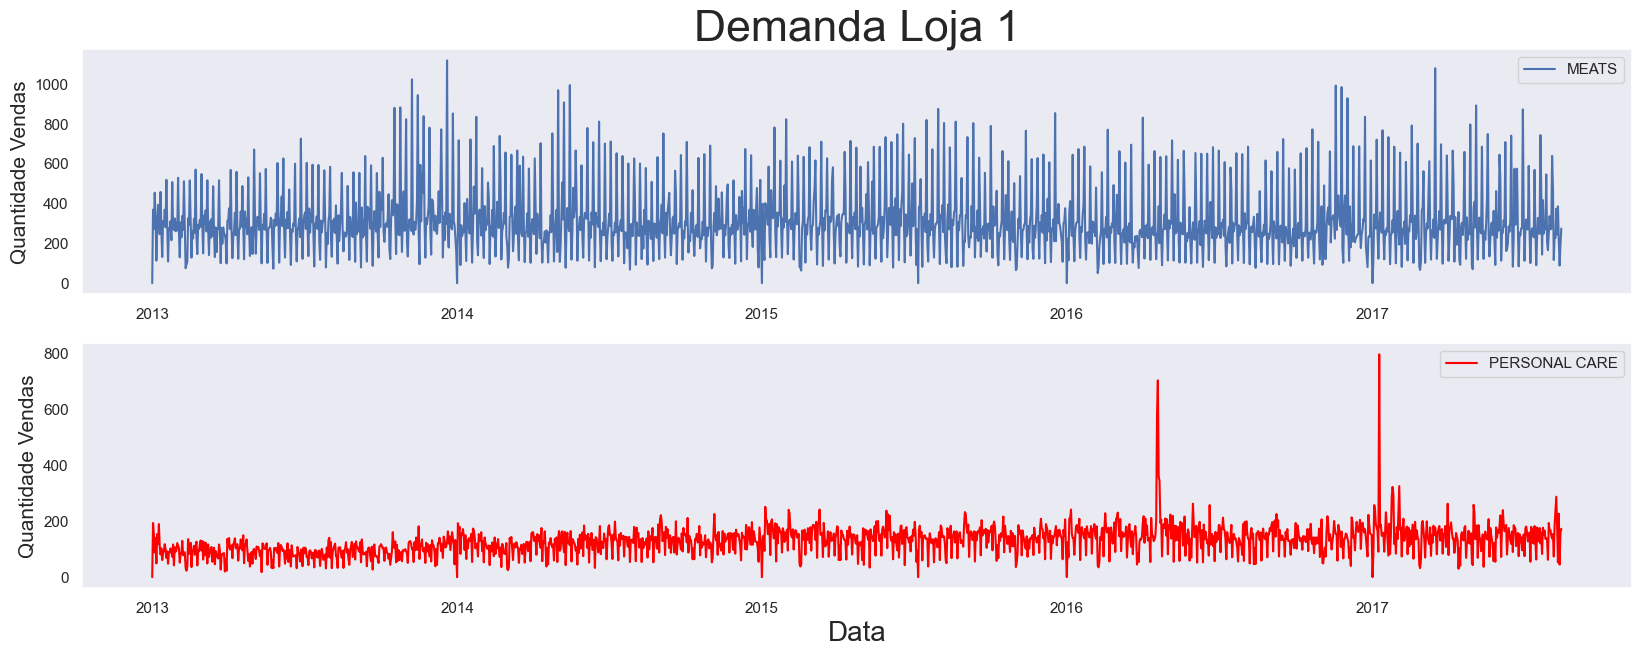

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))

df_=df.loc[(df['store_nbr'] == 1)]
df1=df_[df_.family=='MEATS']
df2=df_[df_.family=='PERSONAL CARE']

ax[0].set_title(f'Demanda Loja 1', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.date,df1.sales,label='MEATS')
ax[0].legend()
ax[0].set_ylabel('Quantidade Vendas', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(df2.date,df2.sales,color='red',label='PERSONAL CARE')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('Quantidade Vendas', fontsize=15)

plt.show()

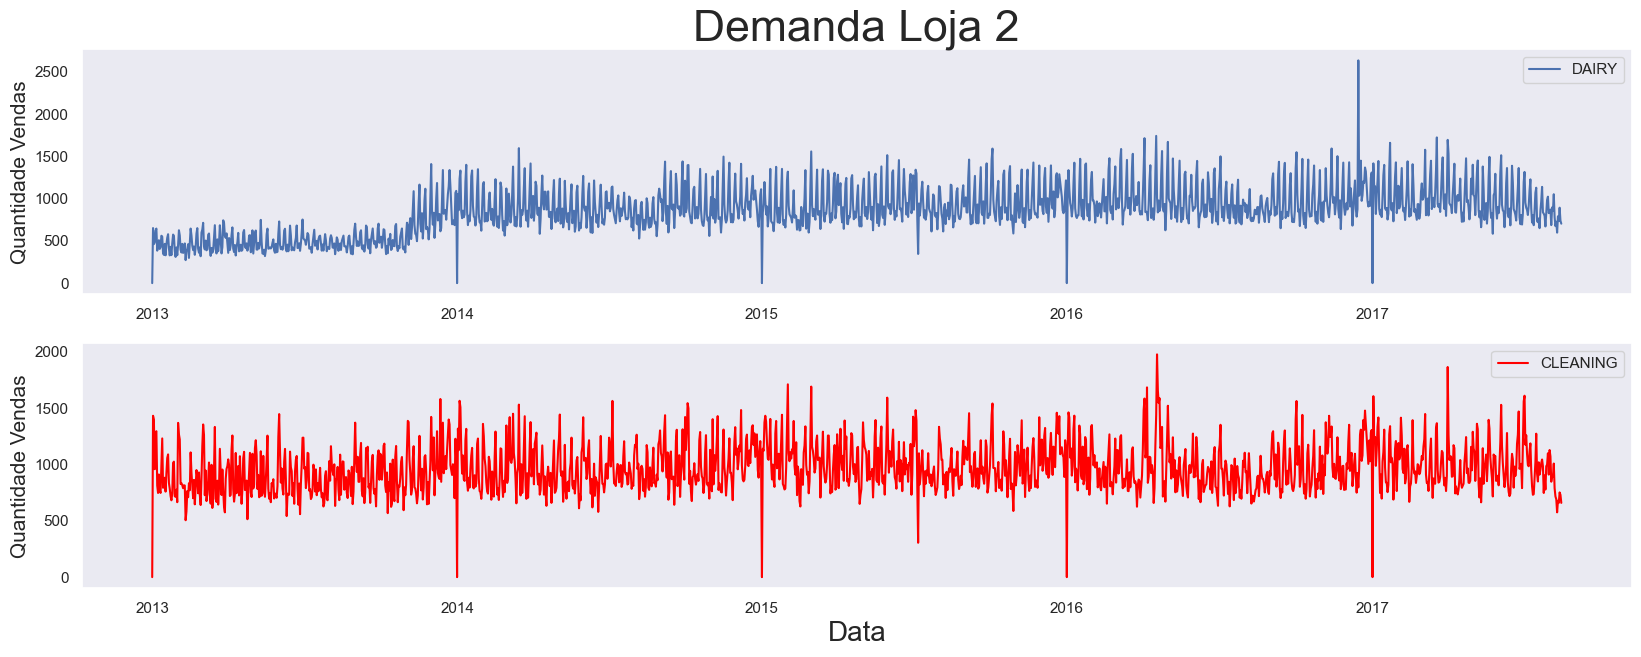

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (20, 7))
#'['DAIRY', 'CLEANING']
df_=df.loc[(df['store_nbr'] == 2)]
df1=df_[df_.family=='DAIRY']
df2=df_[df_.family=='CLEANING']

ax[0].set_title(f'Demanda Loja 2', fontsize=32)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.date,df1.sales,label='DAIRY')
ax[0].legend()
ax[0].set_ylabel('Quantidade Vendas', fontsize=15)
ax[0].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[1].plot(df2.date,df2.sales,color='red',label='CLEANING')
ax[1].legend()
ax[1].grid()
ax[1].set_xlabel('Data', fontsize=20)
ax[1].set_ylabel('Quantidade Vendas', fontsize=15)

plt.show()

In [7]:
print(f"Count of Values of the Onpromotion Variable:")
print(f"Contagem de Valores da Variável Onpromotion:")
df.onpromotion.value_counts()

Count of Values of the Onpromotion Variable:
Contagem de Valores da Variável Onpromotion:


0     3486
1      725
2      491
3      315
4      234
5      155
6      126
7      103
8       99
10      72
9       67
11      42
25      37
22      31
14      31
12      30
45      28
46      27
43      27
15      26
19      26
27      26
20      25
21      25
26      24
23      24
47      24
29      22
24      21
33      21
18      21
13      21
44      20
48      18
35      18
37      18
49      18
28      17
17      17
42      16
40      16
39      16
41      15
16      15
32      14
34      14
36      14
31      13
50      12
30      11
38      11
51       4
52       2
59       2
56       1
61       1
57       1
Name: onpromotion, dtype: int64

In [11]:
print('Total Number of Records:',df.sales.value_counts().sum())
print('Total Null Values:',df.sales.isna().sum())

Total Number of Records: 6736
Total Null Values: 0


In [12]:
print('Quantidade Total de Registros:',df.sales.value_counts().sum())
print('Total de Valores Nulos:',df.sales.isna().sum())

Quantidade Total de Registros: 6736
Total de Valores Nulos: 0


In [38]:
print('Average Sales by Store and Product Category:')
print('Média de Vendas por Loja e Categoria de Produto:')

Average Sales by Store and Product Category:
Média de Vendas por Loja e Categoria de Produto:


<Axes: ylabel='sales'>

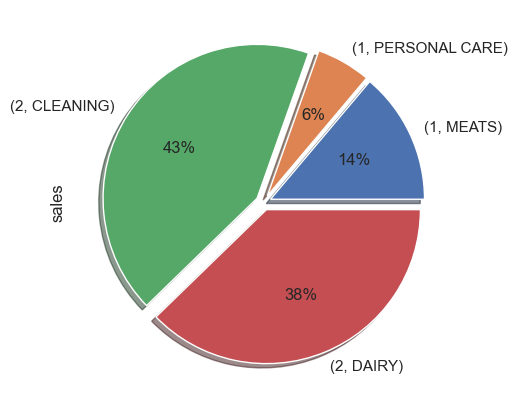

In [37]:
explode = (0.05, 0.05, 0.05, 0.05) 
df.groupby(['store_nbr','family'])['sales'].mean().plot(kind='pie',y='sales', explode=explode, autopct='%1.0f%%',shadow=True, figsize=(5, 5))

# Pre-Processing

## Separates the DataSet into Training and Validation Using a Simple Division Between Past and Future

# Pré-Processamento

## Separa o DataSet em Treino e Validação Utilizando Uma Divisão Simples Entre Passado e Futuro

In [9]:
cut_date='2017-05-15'
train = df.loc[(df['date'] < cut_date)]
valid = df.loc[(df['date'] >= cut_date)]
horizon = valid['date'].nunique()
#_train = train.copy()
#_valid = valid.copy()

In [10]:
print('Horizon Size:')
print('Tamanho do Horizonte:')

Horizon Size:
Tamanho do Horizonte:


In [11]:
print(f' Forecast For {horizon} Days')
print(f'Forecast Para {horizon} Dias')

 Forecast For 93 Days
Forecast Para 93 Dias


## Rename the Variables: 'data', 'store nbr+family' and 'sales' to 'de', 'unique_id' and 'y' respectively, to leave in a suitable format for neuralforecast
## Renomeia as Variáveis: 'date', 'store_nbr+family' e 'sales' Para 'ds','unique_id' e 'y' Respectivamente, Para Deixar em um Formato Adequado Para o neuralforecast

In [12]:
#train,valid=add_target_features(train, valid, stores, oil, holidays, time_feautres, target='sales')
# cria o dataframe de treino unindo com os dataframes de stores, oil e holidays
train = merge_dataframes(train, stores, oil, holidays).drop('cluster',axis=1)
# Renomeia Colunas treino
train = add_unique_id(train)
#train_plot=train.copy()
# cria o dataframe com as features para o forecasting para enviar para a submissão
valid = merge_dataframes(valid, stores, oil, holidays).drop('cluster',axis=1)
# Renomeia Colunas testes
valid = add_unique_id(valid)

In [140]:
print('Mescla os Dataframes: train, stores, oil, holidays e Concatena as Colunas: store_nbr e family, Para a coluna unique_id')
print('Merges the Dataframes: train, stores, oil, holidays and Concatenates the Columns: store_nbr and family, For the unique_id column')

Mescla os Dataframes: train, stores, oil, holidays e Concatena as Colunas: store_nbr e family, Para a coluna unique_id
Merges the Dataframes: train, stores, oil, holidays and Concatenates the Columns: store_nbr and family, For the unique_id column


## Feature Engeeniering

## Engenharia de atributos

In [13]:
# Feature Engeeniering - Adiciona Variáveis Extras: std, média e mediana da variável target:y em train e valid
time_feautres=['unique_id','month','day_of_month']

agg=target_encoding(train,time_feautres,target='y')
agg.index.names=time_feautres
agg.reset_index(inplace=True, level = time_feautres)
train=train.merge(agg,how="left",on=time_feautres)
valid=valid.merge(agg,how="left",on=time_feautres)

In [142]:
print('Adds time features: day of the week, month, year, etc.. and calculates the standard deviation, mean and median of the target variable: y grouped by unique_id, month and day of the month')
print('Adiciona recursos de tempo: dia da semana, mês, ano etc.. e calcula o desvio padrão, média e mediana da variável target: y agrupados por unique_id, mês e dia do mês')

Adds time features: day of the week, month, year, etc.. and calculates the standard deviation, mean and median of the target variable: y grouped by unique_id, month and day of the month
Adiciona recursos de tempo: dia da semana, mês, ano etc.. e calcula o desvio padrão, média e mediana da variável target: y agrupados por unique_id, mês e dia do mês


## Correlation Analysis
## Analise de Correlação

In [143]:
cols=['y', 'onpromotion', 'preco_petroleo', 'is_holiday?', 'year', 'quarter', 'month', 'day_of_month','day_of_year', 'day_of_week', 'week_of_month', 'week_of_year','is_weekeend?', 'std_per_y', 'median_per_y', 'mean_per_y']

<Axes: >

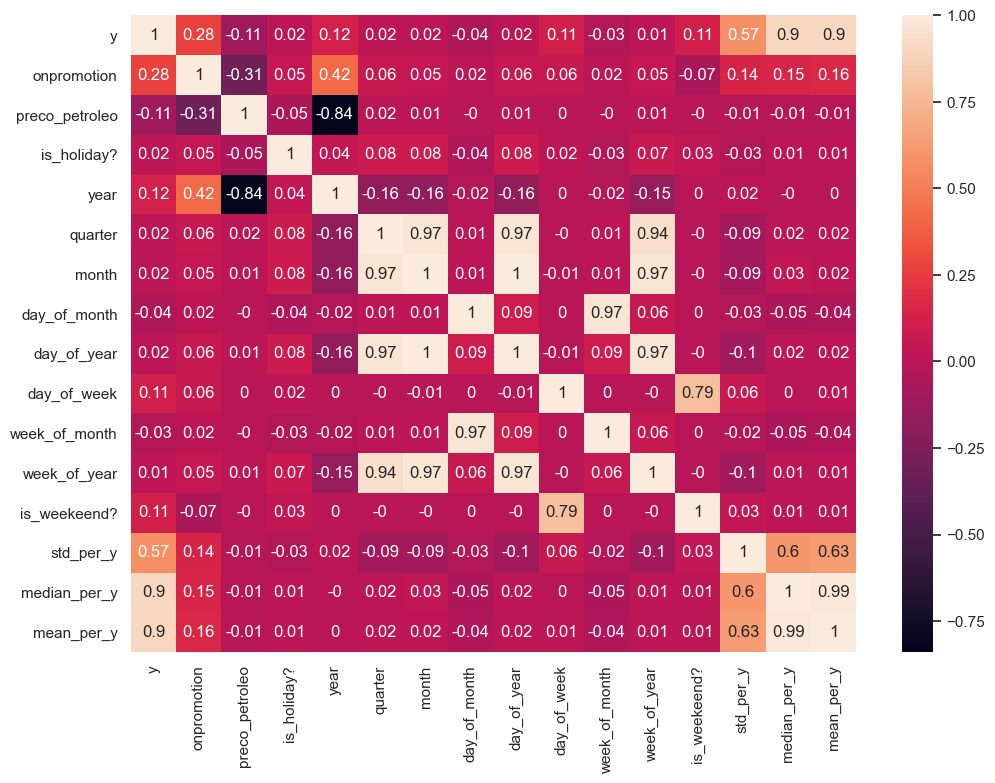

In [144]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(fill_na(train[cols]).copy().corr().round(2),annot=True)

Analyzing the Heat Map We noticed that the Variables that have the highest correlation with the Target Y(Sales) variable are: 'onpromotion', 'std_per_y', 'median_per_y' and 'mean_per_y'.

Analisando o Mapa de Calor Notamos que as Variáveis que Possuem a Maior Correlação com a Variável Target Y(Sales) São: 'onpromotion', 'std_per_y', 'median_per_y' e 'mean_per_y'.

In [14]:
#preenche dados faltantes por interpolação
#ordena valores por unique_id e ds
#transforma os dados usando min-max-scaler
scale_dataset=False #Scale DataSet?
scaler,train=process_data(train, scale_data=scale_dataset)
_,valid=process_data(valid, scale_data=scale_dataset,scale_y=False)

## Viewing the Training and Validation DataFrames

## Visualizando os DataFrames de Treino e Validação

In [146]:
train.head()

,ds,unique_id,y,onpromotion,preco_petroleo,is_holiday?,year,quarter,month,day_of_month,day_of_year,day_of_week,week_of_month,week_of_year,is_weekeend?,std_per_y,mean_per_y,median_per_y
0,2013-01-01,1#MEATS,0.000,0.0,93.140000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000
1,2013-01-02,1#MEATS,369.101,0.0,93.140000,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,114.291342,281.169000,298.455
2,2013-01-03,1#MEATS,272.319,0.0,92.970000,0.0,0.0,0.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,237.474399,324.158340,272.319
3,2013-01-04,1#MEATS,454.172,0.0,93.120000,0.0,0.0,0.0,0.0,3.0,3.0,4.0,0.0,0.0,0.0,123.683895,310.230004,326.203
4,2013-01-05,1#MEATS,328.940,0.0,93.128889,1.0,0.0,0.0,0.0,4.0,4.0,5.0,0.0,0.0,1.0,130.710053,301.661400,328.940


In [147]:
valid.head()

,ds,unique_id,y,onpromotion,preco_petroleo,is_holiday?,year,quarter,month,day_of_month,day_of_year,day_of_week,week_of_month,week_of_year,is_weekeend?,std_per_y,mean_per_y,median_per_y
0,2017-05-15,1#MEATS,259.61100,0.0,48.86,0.0,0.0,1.0,4.0,14.0,134.0,0.0,2.0,19.0,0.0,245.751396,349.75275,305.0680
1,2017-05-16,1#MEATS,218.04700,1.0,48.64,0.0,0.0,1.0,4.0,15.0,135.0,1.0,2.0,19.0,0.0,358.700170,457.74040,286.2550
2,2017-05-17,1#MEATS,300.75500,0.0,49.04,0.0,0.0,1.0,4.0,16.0,136.0,2.0,2.0,19.0,0.0,191.102910,304.71925,261.1015
3,2017-05-18,1#MEATS,418.99402,0.0,49.36,0.0,0.0,1.0,4.0,17.0,137.0,3.0,2.0,19.0,0.0,78.159734,234.45100,268.3245
4,2017-05-19,1#MEATS,749.32000,45.0,50.32,0.0,0.0,1.0,4.0,18.0,138.0,4.0,2.0,19.0,0.0,80.964157,219.41150,245.5490


In [171]:
print("Unique Values for Variable 'unique_id':")
print("Valores Unicos Para a Variável 'unique_id':")

Unique Values for Variable 'unique_id':
Valores Unicos Para a Variável 'unique_id':


In [167]:
train.unique_id.unique()

array(['1#MEATS', '1#PERSONAL CARE', '2#CLEANING', '2#DAIRY'],
      dtype=object)

In [168]:
len(df)

6736

In [169]:
len(train)

6364

In [170]:
len(valid)

372

In [172]:
p=len(valid)/len(train)*100
print('Validation Percentage {}%'.format(round(p,2)))
print('Percentual de Validação {}%'.format(round(p,2)))

Validation Percentage 5.85%
Percentual de Validação 5.85%


## Selects the Algorithm, Optimization Method and Columns that will be Passed to the Model as External Variables

## Seleciona o Algoritmo, Método de Otimização e Colunas que Serão Passadas Para o Modelo Como Variáveis Externas

In [15]:
model_type='NBEATS' # NBEATS,NBEATSx, NHITS, TFT
opt_type=2 #1 or 2
model_path='saved_models/'
cols_scale=train.columns[~train.columns.isin(['y', 'ds', 'unique_id'])].tolist()
cols_scale

['onpromotion',
 'preco_petroleo',
 'is_holiday?',
 'year',
 'quarter',
 'month',
 'day_of_month',
 'day_of_year',
 'day_of_week',
 'week_of_month',
 'week_of_year',
 'is_weekeend?',
 'mean_per_y',
 'std_per_y',
 'median_per_y']

# Optimizes Hyperparameters

# Otimiza os Hiperparâmetros

In [85]:
t0=time.time()
if opt_type==1:
    print("Método de Otimização 1")
    step_=50
    total_train=4000
    scalers=['standard','robust',None]
    models = find_best_parameters(scalers,horizon,cols_scale,model_type=model_type,step_=step_,total_train=total_train)
    #olhar input_size_multiplier=5*h, context_size e hidden_size para TFT
else:
    print("Método de Otimização 2")
    n_samples=50
    if model_type=='NBEATS':
        print('NBEATS-1')
        models = [AutoNBEATS(h=horizon,num_samples=n_samples,loss=WMAPE())]
    elif model_type=='NHITS':
        print('NHITS-1')
        models = [AutoNHITS(h=horizon,num_samples=n_samples,loss=WMAPE())]
    elif model_type=='NBEATSx':
        print('NBEATSx-1')
        models = [AutoNBEATSx(h=horizon,num_samples=n_samples,loss=WMAPE())]
    else:
        print('TFT-1')
        models = [AutoTFT(h=horizon,num_samples=n_samples,loss=WMAPE())]

    model = NeuralForecast(models=models, freq='D')
    model.fit(train)
    results_df = models[0].results.get_dataframe().sort_values('loss')
    print("Combinações de Hiperparâmetros Testadas:")
    print(results_df)
    best_config = models[0].results.get_best_result().metrics['config']
    print("Configuração que Obteve o Melhor Resultado:")
    print(best_config)
    """
    best_config={'h': 93,
     'learning_rate': 0.000789231920391332,
     'scaler_type': None,
     'max_steps': 500,
     'batch_size': 256,
     'windows_batch_size': 1024,
     'loss': WMAPE(),
     'random_seed': 11,
     'input_size': 372,
     'step_size': 1,
     'valid_loss': WMAPE()}
    """
    if model_type=='NBEATS':
        print('NBEATS-2')
        #models = [NBEATS(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=scaler_type,val_check_steps=step_)]
        models = [NBEATS(futr_exog_list=cols_scale,**best_config)]
    elif model_type=='NHITS':
        print('NHITS-2')
        models = [NHITS(futr_exog_list=cols_scale,**best_config)]
    elif model_type=='NBEATSx':
        print('NBEATSx-2')
        #models = [NBEATSx(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=scaler_type,val_check_steps=step_)]
        models = [NBEATSx(futr_exog_list=cols_scale,**best_config)]
    else:
        print('TFT-2')
        #models = [TFT(futr_exog_list=cols_scale,h=h,input_size=5*h,max_steps=best_epoch,loss=WMAPE(),scaler_type=scaler_type,val_check_steps=step_)]
        models = [TFT(futr_exog_list=cols_scale,**best_config)]

t1=time.time()
model = NeuralForecast(models=models, freq='D')
t=float(t1-t0)/60
print(f"Tempo total:{np.round(t,2)} minutos")

Seed set to 1


Método de Otimização 1
scaler_type= standard
NHITS-1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 50
decision_metric= 0.2934613535676125



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 100
decision_metric= 0.27034702726558685



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 150
decision_metric= 0.32776243144132955



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 200
decision_metric= 0.5045369419364683



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 250
decision_metric= 0.364072588907832



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 300
decision_metric= 0.5470406855807327



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 350
decision_metric= 0.5752011961625332



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Seed set to 1
Seed set to 1


Epoch= 400
decision_metric= 0.4968996353065966

epoch= 100
scaler_type= standard
decision_metric= 0.27034702726558685
wmape= 0.15935253741375996
mape= 0.16733675126580175
rmse= 140.35784301756252
r2= 0.8762968221358226
rmsle= 0.27966705779636364
NHITS-2

scaler_type= robust
NHITS-1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 50
decision_metric= 0.2727168024703748



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 100
decision_metric= 0.2784822982673454



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 150
decision_metric= 0.24045986666562638



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 200
decision_metric= 0.24258791815525058



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 250
decision_metric= 0.2581086491087068



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 300
decision_metric= 0.24780122380336758



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 350
decision_metric= 0.26120007600693906



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Seed set to 1


Epoch= 400
decision_metric= 0.2540066443889459

epoch= 150
scaler_type= robust
decision_metric= 0.24045986666562638
wmape= 0.13262927415422618
mape= 0.14838160938571462
rmse= 121.63067005054677
r2= 0.907104712304752
rmsle= 0.2677098089258147
NHITS-2



Seed set to 1


scaler_type= None
NHITS-1


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 50
decision_metric= 0.49223394927891745



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 100
decision_metric= 0.5201618373030032



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 150
decision_metric= 0.46291840050342786



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 200
decision_metric= 0.4678515253859849



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 250
decision_metric= 0.5153871607204368



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 300
decision_metric= 0.4436739438960866



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Epoch= 350
decision_metric= 0.4531291578630028



Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Predicting: |                                                                                    | 0/? [00:00<…

Seed set to 1


Epoch= 400
decision_metric= 0.42997920166568326

NHITS-2

FINISH!!!
best_epoch= 150
best_scaler_type= robust
best_decision_metric= 0.24045986666562638
best_wmape= 0.13262927415422618
best_mape= 0.14838160938571462
best_rmse= 121.63067005054677
best_r2= 0.907104712304752
best_rmsle= 0.2677098089258147
Tempo total:42.15 minutos


## Download the Weights of the Optimized Model
## Baixa os Pesos do Modelo Otimizado

In [16]:
#download model weights

url="https://drive.google.com/uc?id=1RHSRyRdk5jjzEswJlxxboMokVG9kpOPJ&export=download"
file_name='saved_models_1.zip'

model_path=download_files(url=url,path=model_path,filename = file_name)

## Load the Optimized Model Weights
## Carrega os Pesos do Modelo Otimizado

In [18]:
#cria o diretorio se não existir
if not(os.path.isdir(model_path)):
    os.mkdir(model_path)
    
#load model
model = NeuralForecast.load(path=model_path)

Seed set to 11


## Train the Model With Optimized Hyperparameters
## Treina o Modelo Com os Hiperparâmetros Otimizados

In [150]:
type(model)

neuralforecast.core.NeuralForecast

In [87]:
train.shape

(6364, 18)

In [88]:
model.fit(df=train)

Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

## Saves Model Weights After Training
## Salva os Pesos do Modelo Após o Treinamento

In [61]:
#save model
model.save(path=model_path,
        model_index=None,
        overwrite=True,
        save_dataset=True)

## Performs Forecast on Validation Data
## Realiza o Forecast nos Dados de Validação

In [19]:
#model=best_model
#Apaga os valores corretos dos dados de validação antes de passar para o modelo
#valid_.merge(train[['ds','unique_id', 'y']],on=['ds', 'unique_id'], how='left')
#pred = model.predict(futr_df=valid_).reset_index()
pred = model.predict(futr_df=valid.drop('y',axis=1)).reset_index()
pred = pred.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='inner').sort_values(['unique_id','ds'])
pred = pred.rename(columns={model_type: 'predict'})
if scale_dataset:
    print("revert scale")
    pred = invert_scale(scaler, pred, ['predict'])
pred.predict=abs(pred.predict)
#pred.NBEATS=np.exp(pred.NBEATS)

Predicting: |                                                                                    | 0/? [00:00<…

In [20]:
pred

,unique_id,ds,predict,y
0,1#MEATS,2017-05-15,273.206665,259.61100
1,1#MEATS,2017-05-16,297.980896,218.04700
2,1#MEATS,2017-05-17,327.132904,300.75500
3,1#MEATS,2017-05-18,294.959137,418.99402
4,1#MEATS,2017-05-19,656.869873,749.32000
...,...,...,...,...
367,2#DAIRY,2017-08-11,952.383301,790.00000
368,2#DAIRY,2017-08-12,1046.002319,734.00000
369,2#DAIRY,2017-08-13,1187.662354,892.00000
370,2#DAIRY,2017-08-14,901.955078,738.00000


In [153]:
len(pred)

372

# Compare Predictions and Actual Results
# Compara os Resultados das Previsões e os Reais

In [21]:
cond1=pred.unique_id.apply(lambda x:x.split("#")[0]=='1')
cond2=pred.unique_id.apply(lambda x:x.split("#")[0]=='2')

pred_loja1=pred[cond1]
pred_loja2=pred[cond2]

In [22]:
last=-4*horizon
train_ = train.sort_values(by='ds')
cond1_train=train_.unique_id.apply(lambda x:x.split("#")[0]=='1')
cond2_train=train_.unique_id.apply(lambda x:x.split("#")[0]=='2')
train_1=train_[cond1_train]
train_2=train_[cond2_train]
full_loja1 = pd.concat([train_1[last:], pred_loja1])
full_loja2 = pd.concat([train_2[last:], pred_loja2])

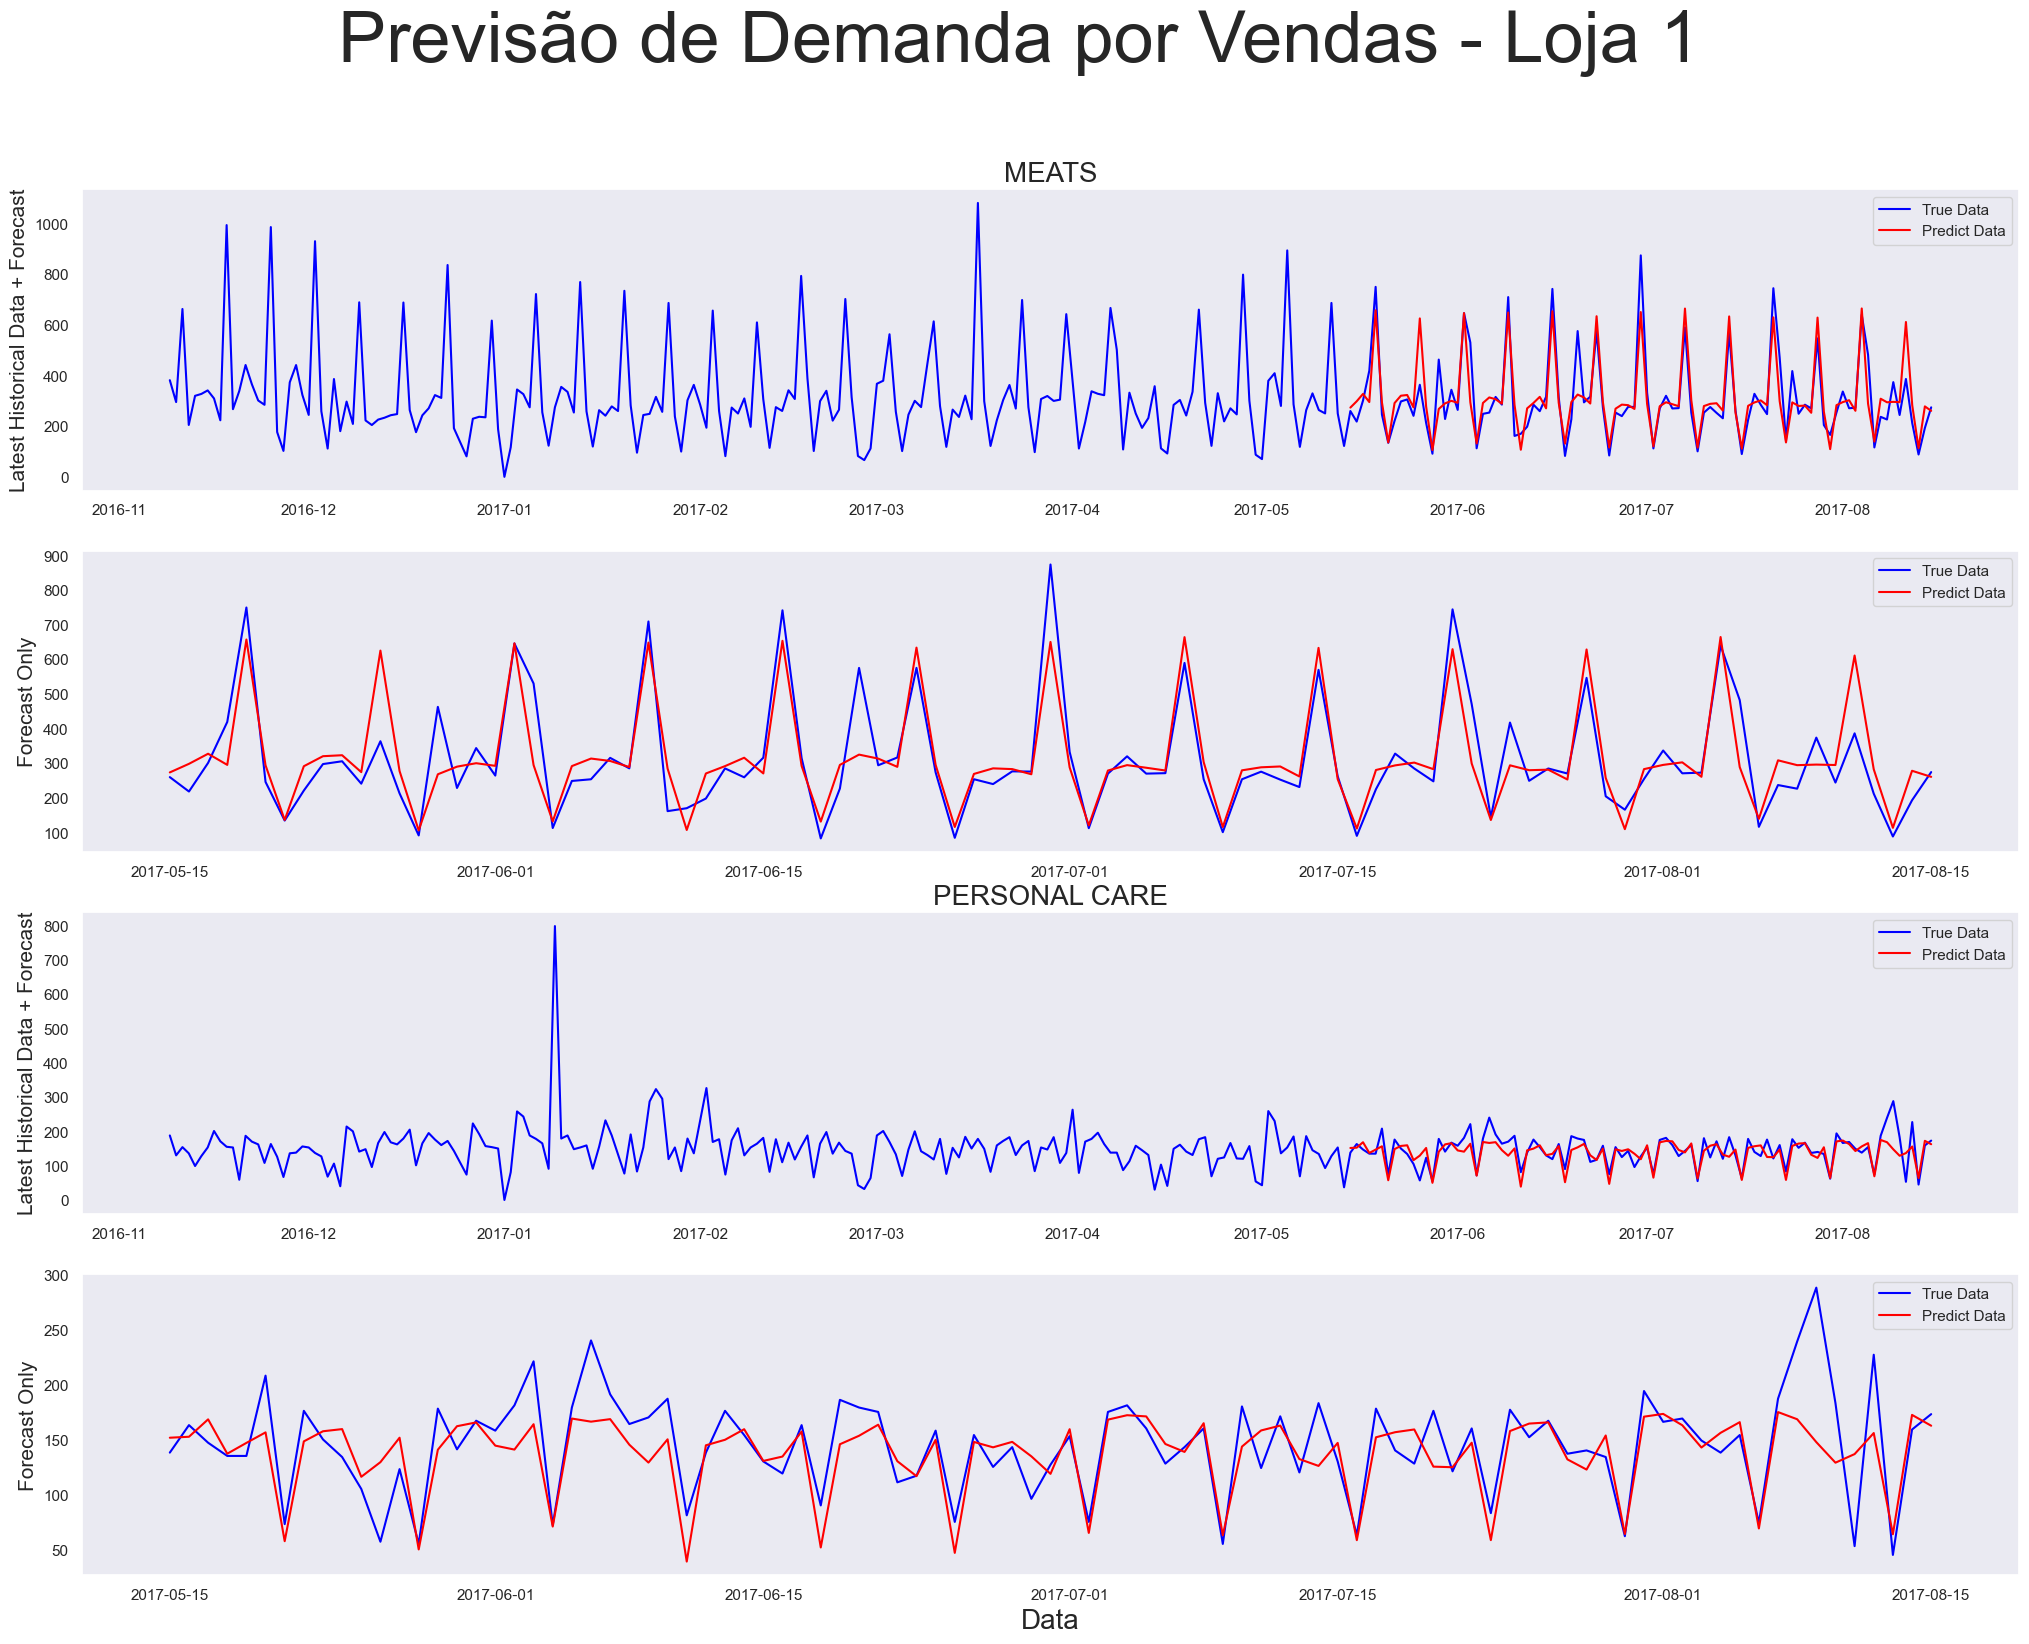

In [156]:
fig, ax = plt.subplots(4, 1, figsize = (25, 18))

condA_=full_loja1.unique_id.apply(lambda x:x.split("#")[1]=='MEATS')
condB_=full_loja1.unique_id.apply(lambda x:x.split("#")[1]=='PERSONAL CARE')

df1=full_loja1[condA_]
df2=full_loja1[condB_]

condA=pred_loja1.unique_id.apply(lambda x:x.split("#")[1]=='MEATS')
condB=pred_loja1.unique_id.apply(lambda x:x.split("#")[1]=='PERSONAL CARE')

dfA1=pred_loja1[condA]
dfB1=pred_loja1[condB]

fig.suptitle(f'Previsão de Demanda por Vendas - Loja 1', fontsize=52)
ax[0].set_title(f'MEATS', fontsize=20)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.ds,df1.y,color='blue',label='True Data')
ax[0].plot(df1.ds,df1.predict,color='red',label='Predict Data')
ax[0].legend()
ax[0].set_ylabel('Latest Historical Data + Forecast', fontsize=15)
ax[0].grid()

ax[1].plot(dfA1.ds,dfA1.y,color='blue',label='True Data')
ax[1].plot(dfA1.ds,dfA1.predict,color='red',label='Predict Data')
ax[1].legend()
ax[1].set_ylabel('Forecast Only', fontsize=15)
ax[1].grid()

ax[2].set_title(f'PERSONAL CARE', fontsize=20)
ax[2].plot(df2.ds,df2.y,color='blue',label='True Data')
ax[2].plot(df2.ds,df2.predict,color='red',label='Predict Data')
ax[2].legend()
ax[2].set_ylabel('Latest Historical Data + Forecast', fontsize=15)
ax[2].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[3].plot(dfB1.ds,dfB1.y,color='blue',label='True Data')
ax[3].plot(dfB1.ds,dfB1.predict,color='red',label='Predict Data')
ax[3].legend()
ax[3].set_xlabel('Data', fontsize=20)
ax[3].set_ylabel('Forecast Only', fontsize=15)
ax[3].grid()

plt.show()

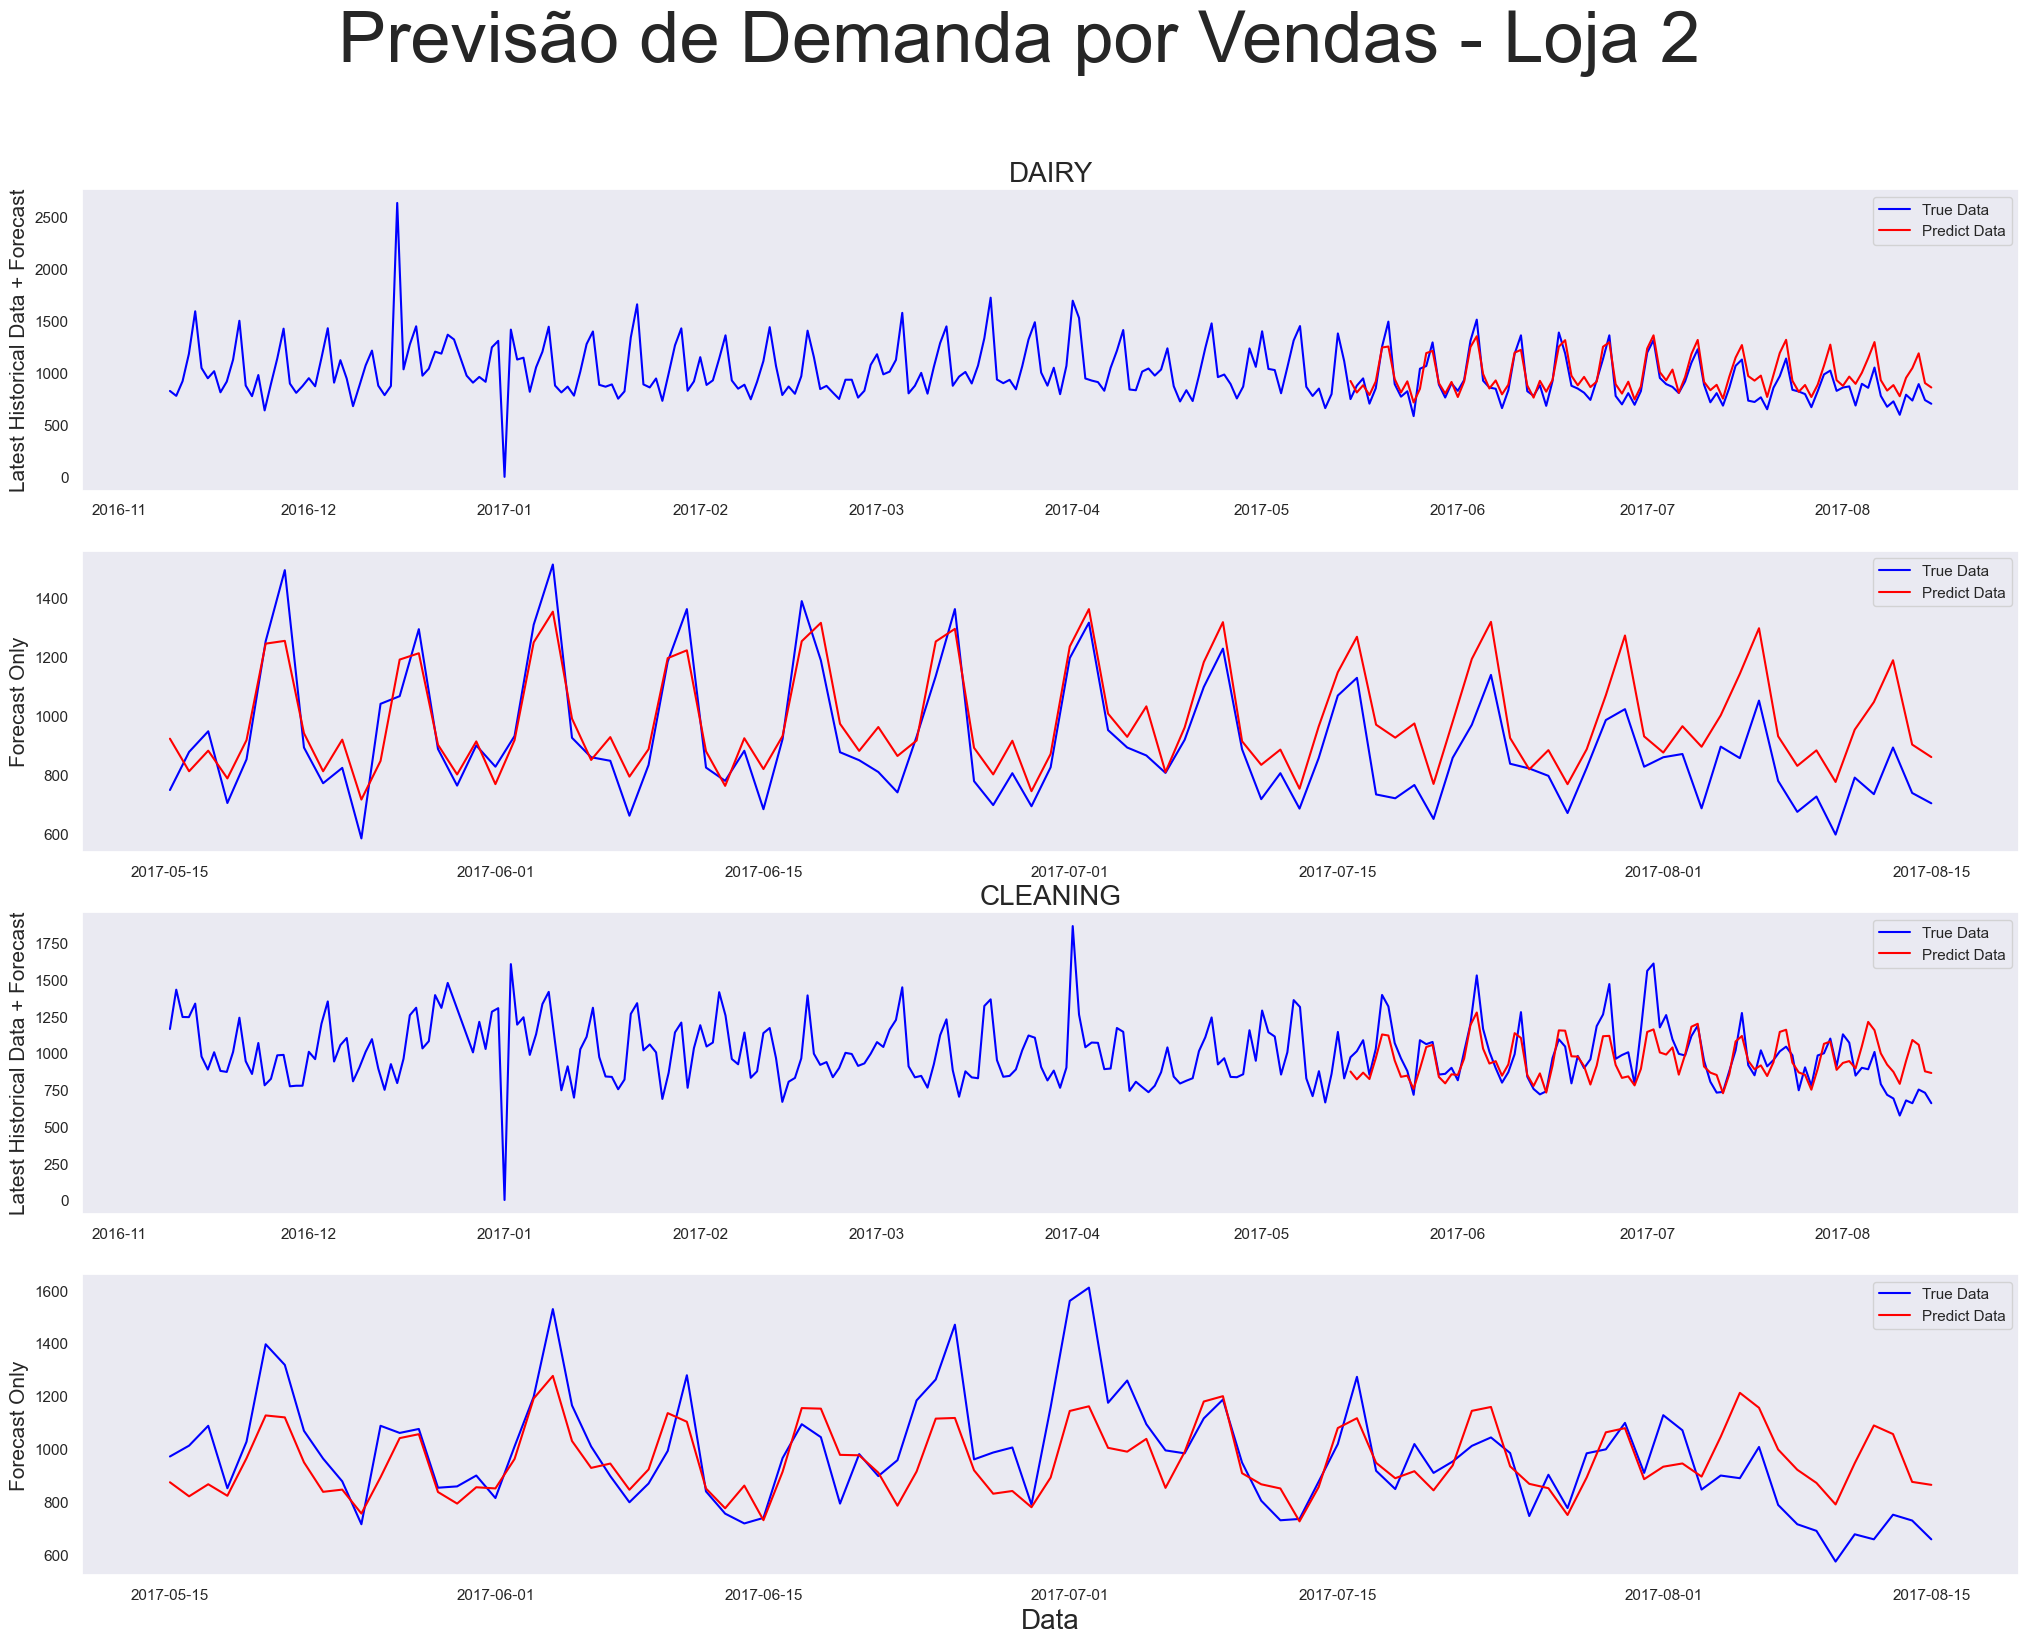

In [23]:
fig, ax = plt.subplots(4, 1, figsize = (25, 18))

condA_=full_loja2.unique_id.apply(lambda x:x.split("#")[1]=='DAIRY')
condB_=full_loja2.unique_id.apply(lambda x:x.split("#")[1]=='CLEANING')

df1=full_loja2[condA_]
df2=full_loja2[condB_]

condA=pred_loja2.unique_id.apply(lambda x:x.split("#")[1]=='DAIRY')
condB=pred_loja2.unique_id.apply(lambda x:x.split("#")[1]=='CLEANING')

dfA2=pred_loja2[condA]
dfB2=pred_loja2[condB]

fig.suptitle(f'Previsão de Demanda por Vendas - Loja 2', fontsize=52)
ax[0].set_title(f'DAIRY', fontsize=20)
#ax[0].set_ylabel('Demanda por Vendas', fontsize=20)
#ax[0].set_xlabel('Data', fontsize=20)
ax[0].plot(df1.ds,df1.y,color='blue',label='True Data')
ax[0].plot(df1.ds,df1.predict,color='red',label='Predict Data')
ax[0].legend()
ax[0].set_ylabel('Latest Historical Data + Forecast', fontsize=15)
ax[0].grid()

ax[1].plot(dfA2.ds,dfA2.y,color='blue',label='True Data')
ax[1].plot(dfA2.ds,dfA2.predict,color='red',label='Predict Data')
ax[1].legend()
ax[1].set_ylabel('Forecast Only', fontsize=15)
ax[1].grid()

ax[2].set_title(f'CLEANING', fontsize=20)
ax[2].plot(df2.ds,df2.y,color='blue',label='True Data')
ax[2].plot(df2.ds,df2.predict,color='red',label='Predict Data')
ax[2].legend()
ax[2].set_ylabel('Latest Historical Data + Forecast', fontsize=15)
ax[2].grid()
#ax[0].set_xlabel('Data', fontsize=20)
ax[3].plot(dfB2.ds,dfB2.y,color='blue',label='True Data')
ax[3].plot(dfB2.ds,dfB2.predict,color='red',label='Predict Data')
ax[3].legend()
ax[3].set_xlabel('Data', fontsize=20)
ax[3].set_ylabel('Forecast Only', fontsize=15)
ax[3].grid()

plt.show()

# Final Results in Evaluation Metrics:
# Resultados Finais nas Métricas de Avaliação:

## General
## Gerais

In [182]:
print(f"Sales Average:{round(train['y'].mean(),3)}")
print(f"Média de Vendas:{round(train['y'].mean(),3)}")

Sales Average:564.18
Média de Vendas:564.18


In [183]:
print(f"Amplitude:{round(train['y'].max()-train['y'].min(),3)}")

Amplitude:2634.0


In [191]:
y_pred=pred['predict'].values
y_true=pred['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("General Results:")
print("Resultados Gerais:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

General Results:
Resultados Gerais:

Decision_Metric = 0.2046
RMSE =  109.9714
MAPE = 12.946 %
WMAPE = 12.1731 %
R2_Score =  0.9241
Pred_Rmsle =  0.198



## Store 1
## Loja 1

In [192]:
y_pred=pred_loja1['predict'].values
y_true=pred_loja1['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("Store 1:")
print("Loja 1:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

Store 1:
Loja 1:

Decision_Metric = 0.2681
RMSE =  61.4467
MAPE = 17.2145 %
WMAPE = 17.5358 %
R2_Score =  0.8224
Pred_Rmsle =  0.2377



## MEATS

In [193]:
y_pred=dfA1['predict'].values
y_true=dfA1['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("MEATS:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

MEATS:

Decision_Metric = 0.2735
RMSE =  80.9427
MAPE = 18.0856 %
WMAPE = 17.8925 %
R2_Score =  0.7554
Pred_Rmsle =  0.2343



## PERSONAL CARE

In [194]:
y_pred=dfB1['predict'].values
y_true=dfB1['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("PERSONAL CARE:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

PERSONAL CARE:

Decision_Metric = 0.2543
RMSE =  31.6177
MAPE = 15.3507 %
WMAPE = 15.6354 %
R2_Score =  0.5149
Pred_Rmsle =  0.2411



## Store 2
## Loja 2

In [195]:
y_pred=pred_loja2['predict'].values
y_true=pred_loja2['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("Store 2:")
print("Loja 2:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

Store 2:
Loja 2:

Decision_Metric = 0.1814
RMSE =  142.8696
MAPE = 11.9126 %
WMAPE = 11.7505 %
R2_Score =  0.5238
Pred_Rmsle =  0.1481



## DAIRY

In [196]:
y_pred=dfA2['predict'].values
y_true=dfA2['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("DAIRY:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

DAIRY:

Decision_Metric = 0.1709
RMSE =  126.8339
MAPE = 11.5811 %
WMAPE = 10.9419 %
R2_Score =  0.6128
Pred_Rmsle =  0.1381



## CLEANING

In [197]:
y_pred=dfB2['predict'].values
y_true=dfB2['y'].values
#wmape = mean_absolute_percentage_error(y_true, y_pred, sample_weight=y_true)
#print("WMAPE: {:.2f}%".format(wmape*100))
decision_metric, pred_r2, pred_wmape, pred_mape, pred_rmse, pred_rmsle=calc_score_error(y_pred,y_true)
decision_metric=round(decision_metric,4)
pred_rmse=round(pred_rmse,4)
pred_mape=round(100*pred_mape,4)
pred_wmape=round(100*pred_wmape,4)
pred_r2=round(pred_r2,4)
pred_rmsle=round(pred_rmsle,4)

print("CLEANING:")
print('\nDecision_Metric =',decision_metric)
print('RMSE = ',pred_rmse)
print(f"MAPE = {pred_mape} %")
print(f"WMAPE = {pred_wmape} %")
print('R2_Score = ',pred_r2)
print('Pred_Rmsle = ',pred_rmsle)
print()

CLEANING:

Decision_Metric = 0.1912
RMSE =  157.2788
MAPE = 12.2195 %
WMAPE = 12.4488 %
R2_Score =  0.4051
Pred_Rmsle =  0.1574

